# Anomaly Detection with `aeon`

ใน Part นี้จะสอนใช้ library ที่ชื่อ AEON ซึ่งมี part สำหรับ Anomaly detection
Document : https://www.aeon-toolkit.org/en/stable/


Input data format:
สำหรับ Lab นี้เราจะกำหนดให้ `m` เป็นขนาดของ time series หรือจำนวน data points. หมายเหตุใน Lab นี้จะมุุ่งเน้น **Univariate** time series เราสามารถกำหนดตัวแปร time series ได้หลายรูปแบบ:

   - `np.ndarray`, shape `(m,)`, `(m, 1)`,  `(1, m)`
   - `pd.DataFrame`, shape `(m, 1)`, `(1, m)`
   - `pd.Series`, shape `(m,)`.

แต่ในกรณีที่ **Multivariate** time series เราสามารเพิ่ม `d` สำหรับจำนวน channels ของ time series.
The detectors have different capabilities that can be grouped into the following
categories, where `m` is the number of time points and `d` is the number of channels for
a time series:

Output data format:

- Anomaly **scores** (default):
  `np.ndarray`, shape `(m,)` of type `float`. สำหรับแต่ละ index จะแสดงค่า anomaly score (float) เพื่อวัดคะแนนการเกิดเหตุการณ์ผิดปกติ (คะแนนสูงมีโอกาสเป็นค่าผิดปกติ)

- **Binary** classification:
  `np.ndarray`, shape `(m,)` of type `bool` or `int`. สำหรับแต่ละ index จะแสดง class ที่เกิดขึ้นว่าเป็นค่าผิดปกติหรือเป็นค่าปกติ โดย:
        - `True`/`1` แทน class ผิดปกติ (anomalous)
        - `False`/`0` แทน class ไม่ผิดปกติ

Detector learning types:



In [1]:
!pip install aeon matplotlib seaborn pyod stumpy prts pytouch 



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
A subdirectory or file data already exists.
Error occurred while processing: data.


In [ ]:
from aeon.datasets import load_anomaly_detection
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X1, Y1 = load_anomaly_detection(
    name=("KDD-TSAD", "197_UCR_Anomaly_tiltAPB1")
)  
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(X1)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(Y1)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
plt.tight_layout()
plt.show()

In [ ]:
from aeon.anomaly_detection import STOMP

est = STOMP(window_size=200)
scores = est.fit_predict(X1)
axes[0].plot(X1)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(Y1)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(scores)
axes[2].set_title("STOMP")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")

plt.tight_layout()
plt.show()

Range-PR-AUC score of k-Means with w=200 on KDD dataset: 0.8428


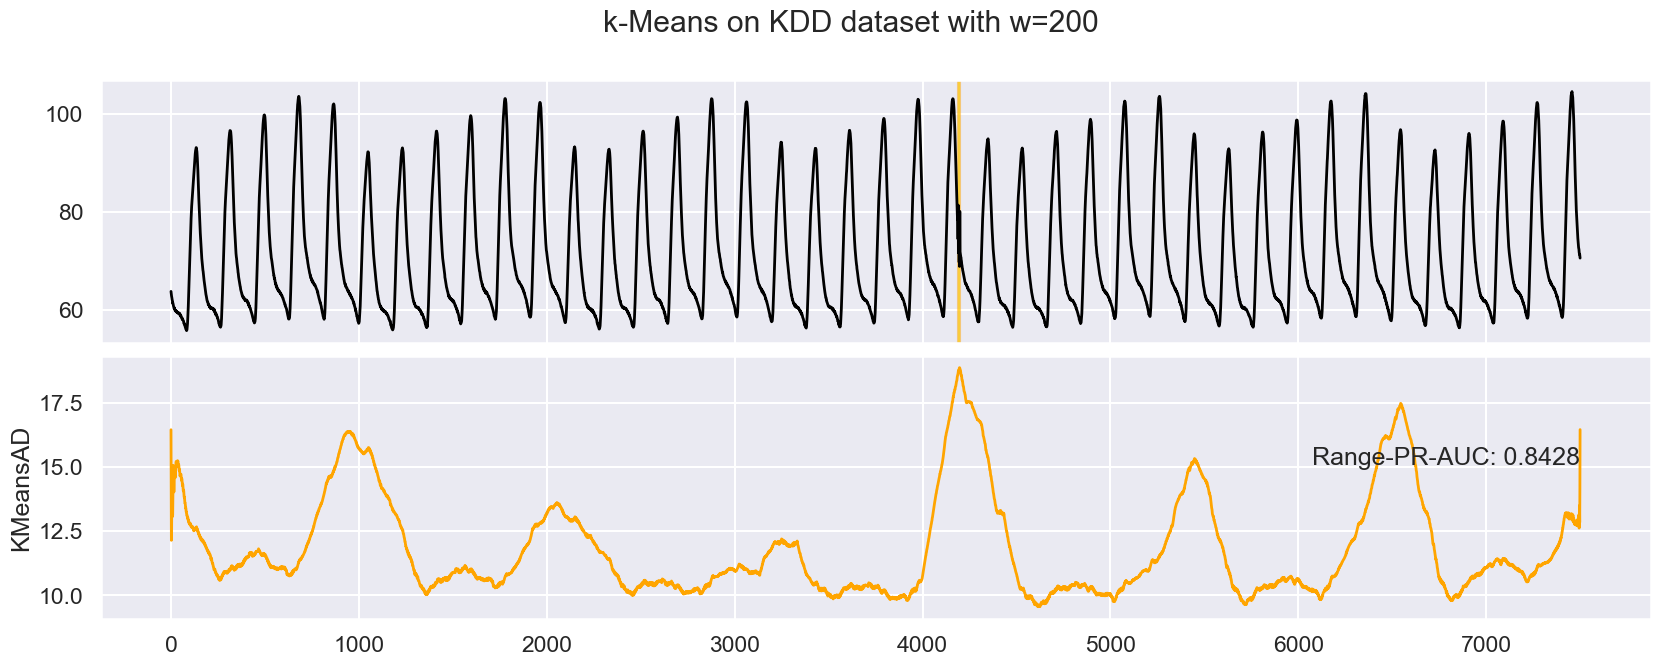

In [9]:
from aeon.anomaly_detection import KMeansAD

# window size for preprocessing the time series before applying k-Means:
w=200

est = KMeansAD(n_clusters=200, window_size=w, random_state=42)
scores = est.fit_predict(X1)

axes[0].plot(X1)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(Y1)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(scores)
axes[2].set_title("STOMP")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")

plt.tight_layout()
plt.show()


Range-PR-AUC score of Subsequence IF on Taxi dataset: 0.0060
Range-PR-AUC score of IF on Taxi dataset: 0.0049


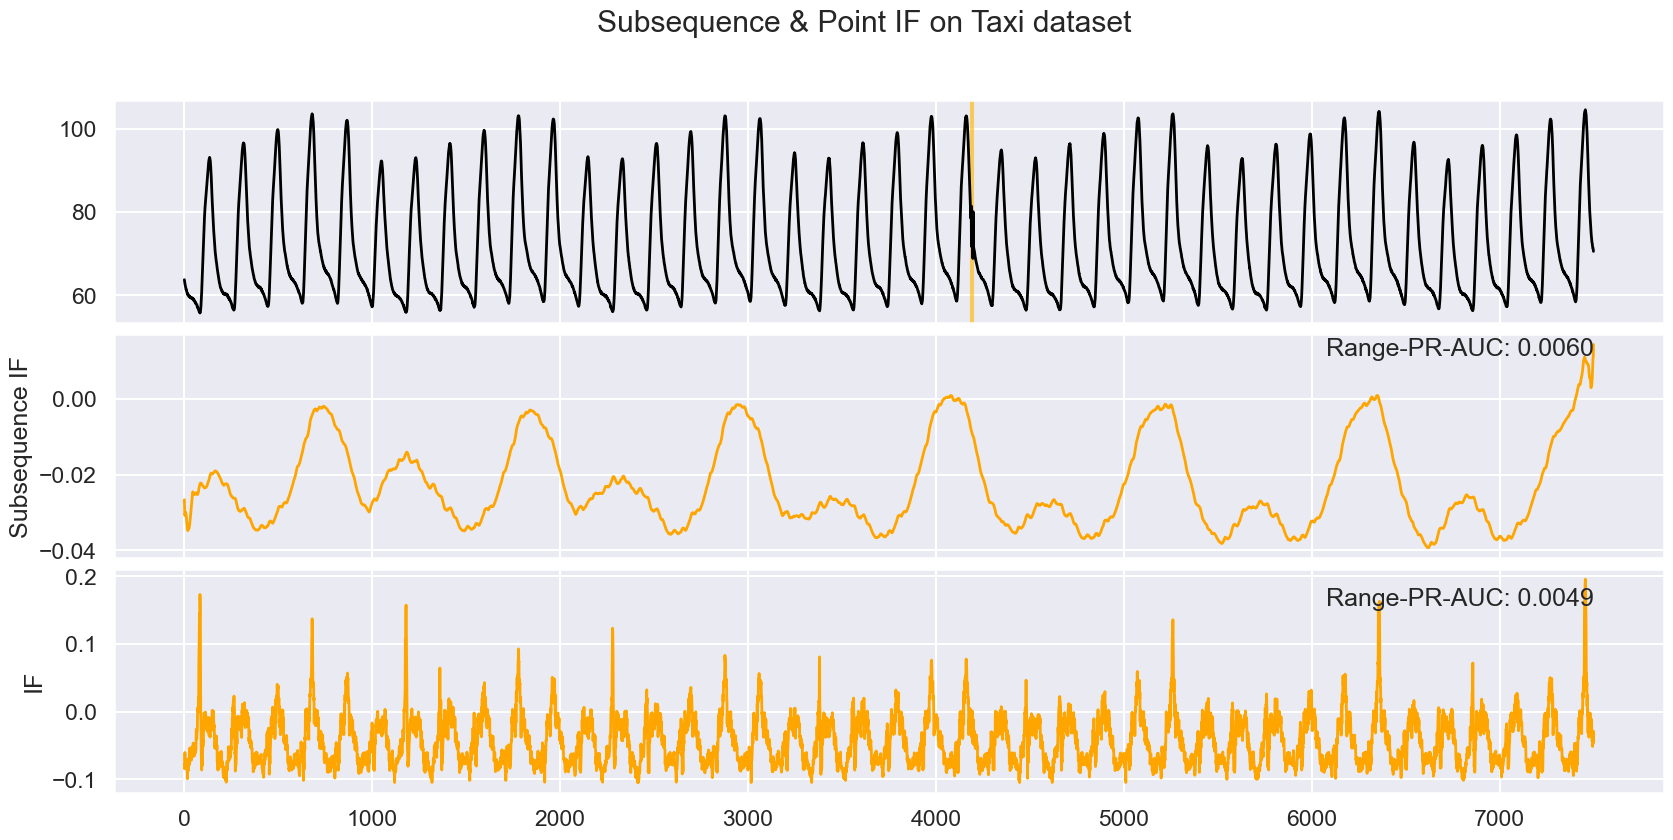

In [13]:
from aeon.anomaly_detection import PyODAdapter
from pyod.models.iforest import IForest

sub_if = PyODAdapter(IForest(), window_size=200)
sub_if_scores = sub_if.fit_predict(X1)

axes[0].plot(X1)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(Y1)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(sub_if_scores)
axes[2].set_title("STOMP")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")

plt.tight_layout()
plt.show()


Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s]


Range-PR-AUC score of AutoEncoder on KDD dataset: 0.0250


Text(7501, 1.177947769165039, 'Range-PR-AUC: 0.0250')

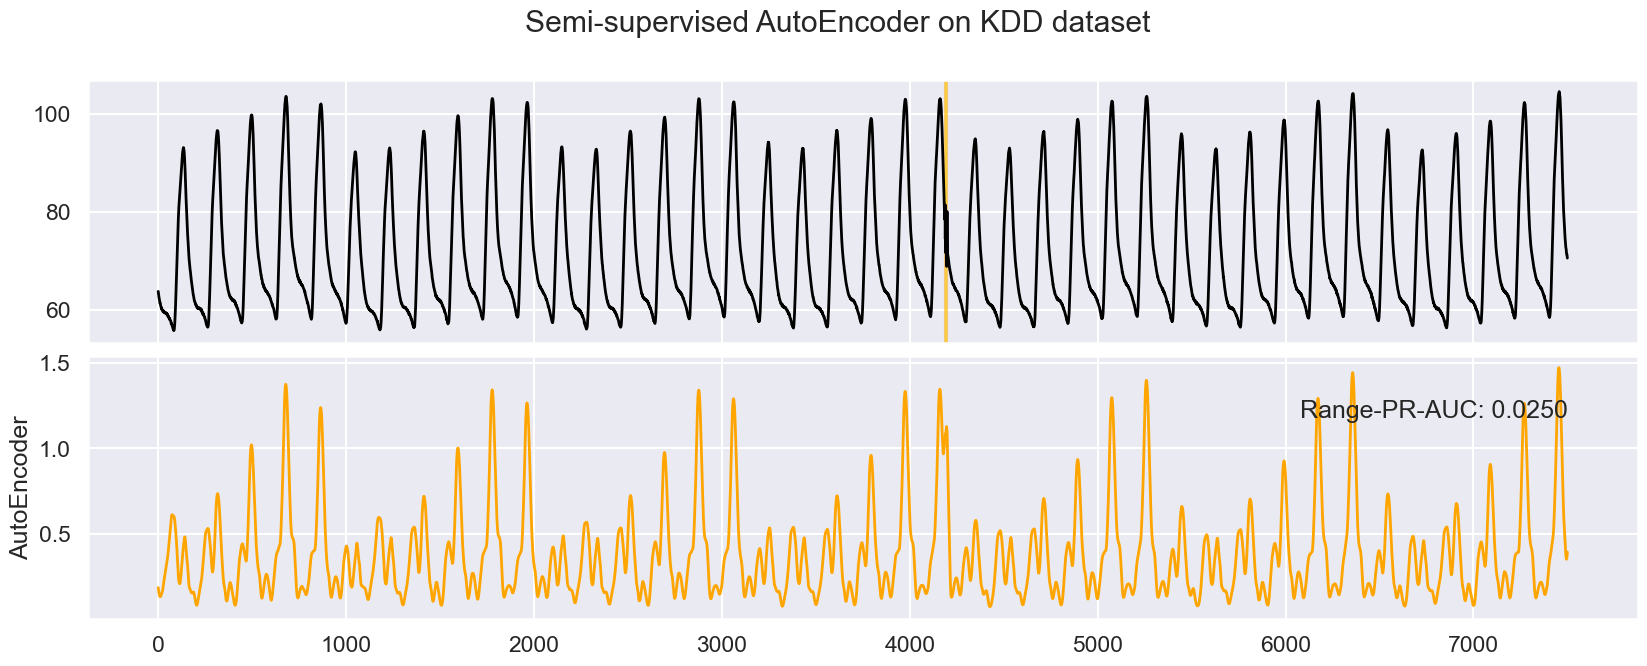

In [17]:
from aeon.anomaly_detection import PyODAdapter
from pyod.models.auto_encoder import AutoEncoder

est = PyODAdapter(AutoEncoder(epoch_num=50), window_size=20, stride=1)
# build normal model on time series without anomalies
est.fit(X_train)

# detect anomaly in target time series
scores = est.predict(X)

quality = range_pr_auc_score(y, scores)
print(f"Range-PR-AUC score of AutoEncoder on KDD dataset: {quality:.4f}")
fig, axs = plot_anomaly_detection(X, y, scores={"AutoEncoder": scores}, title=f"Semi-supervised AutoEncoder on KDD dataset")
axs[-1].text(len(X), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

In [ ]:
from aeon.benchmarking.metrics.anomaly_detection import f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score
from pyod.models.lof import LOF

# Execute the detectors on both univariate datasets
detectors = {
    "STOMP": STOMP(window_size=100),
    "K-Means": KMeansAD(n_clusters=50, window_size=100, random_state=42),
    "Sub-LOF": PyODAdapter(LOF(), window_size=100),
    "Sub-IF": PyODAdapter(IForest(), window_size=100),
    "IF": PyODAdapter(IForest(), window_size=1),
    # ! Attention ! we use the AutoEncoder unsupervised, which is not recommended
    "AE": PyODAdapter(AutoEncoder(), window_size=100)
}
datasets = {
    "KDD": X,
    "Taxi": X_nyc_taxi
}
ground_truths = {
    "KDD": y,
    "Taxi": y_nyc_taxi
}
scores = {}
metrics = []
for d in datasets:
    scores[d] = {}
    for detector in detectors:
        est = detectors[detector]
        score = est.fit_predict(datasets[d])
        scores[d][detector] = score
        entry = {"dataset": d, "algorithm": detector}
        for m in [f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score]:
            entry[m.__name__] = m(ground_truths[d], score)
        metrics.append(entry

In [ ]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

df = (pd.DataFrame(metrics)
      .sort_values("range_pr_auc_score", ascending=False)
      .reset_index(drop=True)
)
cd = df.pivot(index="algorithm", columns="dataset")
plot_critical_difference(cd.values, cd.index)
df